# PRONÓSTICO DEL AVALUO DE VIVIENDAS

## CAPITULO I. Reducción de la dimensionalidad y prealistamiento de datos
_____

Buscando lograr una mayor eficiencia en el proceso de pronóstico se realiza una limpieza preliminar de variables buscando incorporar aquellas  que pueden llegar a explicar de mejor manera el comportamiento del avaluó de viviendas.

### i) Variables que  que por criterio de negocio no se consideran dentro del análisis
- **Variables concentradas:** como objeto, motivo, tipo_credito se encuentran altamente concentradas en una categoria, por ello buscando reducir la complejidad del modelo se eliminan.

- **Variables texto:** casos como dirección_inmueble y descripciones aportan información valiosa pero en un primer acercamiento no se tendrán en cuenta.


> Un mayor detalle de las variables se encuentra en el archivo "Diccionario-variables.xlsx"


### ii) Unificación de variables
- **Areas sociales:** el tener porteria, piscina, biciletero se unifican en una sola variable llamada areas_sociales de tal suerte que tener mas de 8 áreas  sociales es excelente, entre 4 y 8 bueno y menor a 4 regular.
- **Numero de habitaciones, cocina y otros:** se unifican el numero de espacios del predio
- **Area construida:** es la suma de todas las areas de la vivienda
- **Estado terminados:** se unifican las variables de estado de acabados de la vivienda usando puntajes de acuerdo a la calidad de los acabados.
- **Tipo uso inmueble** a partir del numero de locales, oficinas y de las variables area_actividad y uso_principal_ph se determina si es una vivienda residencial, comercial o mixta.
- **Trece ciudades principales:** se determina si el inmueble se encuentra en una de las trece ciudades principales de Colombia.
- **Puntos de interés:** se determina cuantos puntos de interés hay en un radio de 0.003 grados de latitud y longitud.

In [414]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [415]:
#Cargue de datos ,instanciamiento de parametros generales y algunas funciones genericas
baseAvaluos = pd.read_csv("train_precios_vivienda.csv", sep = ",", dtype="str", encoding="utf-8")

puntosInteres = []
with open("puntosInteres.csv", encoding='ISO-8859-1') as archivo:
    for linea in archivo:
        if linea != "\n" :
            puntosInteres.append(linea.replace("\n","").split(";"))
puntosInteres = pd.DataFrame(puntosInteres, columns = ["longitud", "latitud", "punto_interes","tipo"])
puntosInteres["latitud"] = puntosInteres["latitud"].astype(float)
puntosInteres["longitud"] = puntosInteres["longitud"].astype(float)

parametros = pd.read_excel("Diccionario-variables.xlsx", sheet_name="Parametros")

SELECCION_VARIABLES = list(parametros['variables_incluye'].drop_duplicates().dropna())
baseAvaluos = baseAvaluos[SELECCION_VARIABLES]

UMBRAL_ESPACIAL = 0.003

CONSOLIDA_VARIABLES = {
    "areas_sociales": {
        "variables": ["porteria", "citofono", "bicicletero", "piscina", "tanque_de_agua",
                  "club_house", "garaje_visitantes", "teatrino", "sauna", 
                  "vigilancia_privada"],
        "criterios":{"SI":1},
        "umbrales":{"e": 8, "b": 4, "r": 0}    
    },
    "estado_terminados":{
        "variables" : ["estado_acabados_pisos", "estado_acabados_muros", "estado_acabados_techos", "estado_acabados_madera",
                       "estado_acabados_metal", "estado_acabados_banos", "estado_acabados_cocina"],
        "criterios":{"LUJOSO":10, "BUENO":8, "NORMAL":5, "SENCILLO":5,"REGULAR":2},
        "umbrales":{"e": 60, "b": 45, "r": 25, "m": 0}
    },
    "luz_iluminacion":{
        "variables" :["iluminacion", "ventilacion"],
        "criterios":{"BUENO":10, "REGULAR":5},
        "umbrales":{"e": 15, "b": 10, "r": 0}
    }
     
}
SUMA_VARIABLES ={
    "numero_habitaciones":["habitaciones", "estar_habitacion","cuarto_servicio"],
    "numero_banos":["bano_privado", "bano_social", "bano_servicio"],
    "otros_espacios":["estudio", "balcon", "terraza", "patio_interior", "jardin"],
    "area_construida":["area_privada","area_garaje","area_deposito", "area_construccion", "area_otros", "area_terreno", "area_libre"],
        
}
VARIABLES_TRANSFORMA_NUMERO = ["valor_total_avaluo", "area_valorada", "local", "oficina", "bodega", "Latitud", "Longitud", "estrato", "sala", "comedor", "cocina", "total_cupos_parquedaro", "numero_total_depositos"]

TRECE_CIUDADES_PRIN = ["BOGOT", "MEDELL", "CALI", "BARRANQUILLA", "CARTAGENA", "BUCARAMANGA", "C.CUTA", "IBAGU", "PEREIRA", "MANIZALES", "PASTO", "VILLAVICENCIO", "MONTER"]

DEPARTAMENTOS = list(parametros["departamentos"].drop_duplicates().dropna())

CARACTERES_ESPECIALES = {"Ã\x8d":"I",  "Í":"I", "Ã\x81":"A", "Á":"A", "Ã“":"O", "Ó":"O", "Ã‘":"N", "Ñ":"N", "É":"E", "Ã‰":"E" }

def transformaNumero(baseOrigen: pd.DataFrame, variablesUsar: list) -> pd.DataFrame:
    """
    Funcion que transforma las variables de un dataframe en numericas siguiendo algunas reglas de reemplazo de caracteres
    string que no son numericos
     
    """
    baseEspecifica = baseOrigen[variablesUsar].copy().fillna(0)
    baseEspecifica[variablesUsar] = baseEspecifica[variablesUsar].replace(r"[^0-9.\-,]", "",regex = True) #que no contenga digitos o punto reemplaza por ""
    baseEspecifica[variablesUsar] = baseEspecifica[variablesUsar].replace(r"[,]", ".",regex = True) #reemplaza comas por puntos
    baseEspecifica[variablesUsar] = baseEspecifica[variablesUsar].replace(r"\.{2,}", ".",regex = True) #dos puntos seguidos reemplaza por uno solo
    baseEspecifica[variablesUsar] = baseEspecifica[variablesUsar].replace("","0")
    baseEspecifica[variablesUsar] = baseEspecifica[variablesUsar].replace(".","0")
    baseEspecifica[variablesUsar] = baseEspecifica[variablesUsar].replace(".0.0","0")
    baseEspecifica[variablesUsar] = baseEspecifica[variablesUsar].replace(".10.","0")
    baseEspecifica[variablesUsar] = baseEspecifica[variablesUsar].replace(".5.","0")
    baseEspecifica[variablesUsar] = baseEspecifica[variablesUsar].replace(".2010.","0")
    baseEspecifica[variablesUsar] = baseEspecifica[variablesUsar].replace("-","0")
    baseEspecifica[variablesUsar] = baseEspecifica[variablesUsar].astype(float)
    
    return baseEspecifica

In [416]:
def construyeVariablesCombinadas(baseOrigen: pd.DataFrame, variablesCombinadas:dict) -> pd.DataFrame:
    baseCalculo = baseOrigen.copy()
    #Itera sobre las variables nuevas a crear
    for nuevaVar in variablesCombinadas.keys():
        variablesCombinar = variablesCombinadas[nuevaVar]["variables"]
        criteriosCorte = variablesCombinadas[nuevaVar]["criterios"]
        umbrales = variablesCombinadas[nuevaVar]["umbrales"]
        baseVariablesCombinar = baseCalculo[variablesCombinar].copy()
        #itera sobre cada variable que compone la variable combinada
        for variable in variablesCombinar:
            baseVariablesCombinar[variable + "_tmp"] = 0
            #asigna un puntaje dependiendo del criterio
            for criterio in criteriosCorte.keys():
                baseVariablesCombinar[variable + "_tmp"] = np.where(
                    baseVariablesCombinar[variable].str.upper() == criterio,
                    criteriosCorte[criterio],
                    baseVariablesCombinar[variable + "_tmp"]
                )
            baseVariablesCombinar[variable] = baseVariablesCombinar[variable + "_tmp"]
        
        #realiza la suma de los puntajes asignados a cada variable
        baseVariablesCombinar[nuevaVar + "_numero"] = baseVariablesCombinar[variablesCombinar].sum(axis=1)
        
        #asigna un rango dependiendo de la suma de los puntajes
        baseVariablesCombinar[nuevaVar] = ""
        for umbral in umbrales:
            baseVariablesCombinar[nuevaVar] = np.where(
                ((baseVariablesCombinar[nuevaVar + "_numero"] >= umbrales[umbral]) &
                 (baseVariablesCombinar[nuevaVar] == "")), 
                umbral, 
                baseVariablesCombinar[nuevaVar]
            )
        #elimina las variables que se combinaron
        baseCalculo.drop(variablesCombinar, axis=1, inplace=True)
        baseCalculo = pd.concat([baseCalculo, baseVariablesCombinar[nuevaVar]], axis=1)
        
        print(f"Variable {nuevaVar} creada")
    return baseCalculo
      
baseAvaluos = construyeVariablesCombinadas(baseOrigen = baseAvaluos, variablesCombinadas = CONSOLIDA_VARIABLES)

Variable areas_sociales creada
Variable estado_terminados creada
Variable luz_iluminacion creada


In [417]:
#construye variables que son el resultado de sumar otras
def construyeVariablesSuma(baseOrigen: pd.DataFrame, variablesSuma:dict) -> pd.DataFrame:
    baseCalculo = baseOrigen.copy()
    for nuevaVar in variablesSuma.keys():
        variablesUsar = variablesSuma[nuevaVar]
        
        baseEspecifica = transformaNumero(baseOrigen = baseCalculo, variablesUsar = variablesUsar)
        baseEspecifica[nuevaVar] = baseEspecifica[variablesUsar].sum(axis=1)
        
        baseOrigen = pd.concat([baseOrigen, baseEspecifica[nuevaVar]], axis=1)
        baseOrigen.drop(variablesUsar, axis=1, inplace=True)
        print(f"Variable {nuevaVar} creada")
    return baseOrigen

baseAvaluos = construyeVariablesSuma(baseOrigen = baseAvaluos, variablesSuma = SUMA_VARIABLES)

Variable numero_habitaciones creada
Variable numero_banos creada
Variable otros_espacios creada
Variable area_construida creada


In [418]:
#transforma algunas variables a numericas
def transformaNumericas(baseOrigen: pd.DataFrame, variablesUsar: list) -> pd.DataFrame:
    baseEspecifica = transformaNumero(baseOrigen = baseOrigen, variablesUsar = variablesUsar)
    baseEspecifica[variablesUsar] = baseEspecifica[variablesUsar].astype(float)
    
    for variable in variablesUsar:
        baseOrigen[variable] = baseEspecifica[variable]
    print(f"Variables {variablesUsar} transformadas a numericas")
    return baseOrigen

baseAvaluos = transformaNumericas(baseOrigen = baseAvaluos, variablesUsar = VARIABLES_TRANSFORMA_NUMERO)

Variables ['valor_total_avaluo', 'area_valorada', 'local', 'oficina', 'bodega', 'Latitud', 'Longitud', 'estrato', 'sala', 'comedor', 'cocina', 'total_cupos_parquedaro', 'numero_total_depositos'] transformadas a numericas


In [419]:
#crea variable para determinar si es una vivienda residencial o comercial
def determinaTipoVivienda(baseOrigen: pd.DataFrame) -> pd.DataFrame:
    baseCalculo = baseOrigen.copy()
    variablesNumericas = ["local", "oficina", "bodega"]
    variablesCategoricas = ["area_actividad", "uso_principal_ph"]
    
    baseCalculo["suma_comercial"] = baseCalculo[variablesNumericas].sum(axis=1)
    baseCalculo["tipo_uso_inmueble"] = ""
    baseCalculo["tipo_uso_inmueble"] = np.where(
        baseCalculo["suma_comercial"] > 0,
        "c",
        ""
    )
    baseCalculo.drop("suma_comercial", axis=1, inplace=True)
    for categorica in variablesCategoricas:
        filtroFaltantes = baseCalculo["tipo_uso_inmueble"] == ""
        filtroComercial = baseCalculo[categorica].str.upper().str.contains("COMERC")
        filtroResidencial = baseCalculo[categorica].str.upper().str.contains("RESID")
        filtroMixto = filtroComercial & filtroResidencial
        
        #uso mixto
        baseCalculo["tipo_uso_inmueble"] = np.where(
            (filtroFaltantes & filtroMixto),
            "m",
            baseCalculo["tipo_uso_inmueble"]
        )
        filtroFaltantes = baseCalculo["tipo_uso_inmueble"] == ""
        #uso comercial
        baseCalculo["tipo_uso_inmueble"] = np.where(
            (filtroFaltantes & filtroComercial),
            "c",
            baseCalculo["tipo_uso_inmueble"]
        )
        filtroFaltantes = baseCalculo["tipo_uso_inmueble"] == ""
        #uso residencial
        baseCalculo["tipo_uso_inmueble"] = np.where(
            (filtroFaltantes & filtroResidencial),
            "r",
            baseCalculo["tipo_uso_inmueble"]
        )
        #sin datos de uso
        filtroFaltantes = baseCalculo["tipo_uso_inmueble"] == ""
        baseCalculo["tipo_uso_inmueble"] = np.where(
            filtroFaltantes,
            "n",
            baseCalculo["tipo_uso_inmueble"]
        )
        
    baseCalculo.drop(variablesNumericas, axis=1, inplace=True)
    baseCalculo.drop(variablesCategoricas, axis=1, inplace=True)
    print("Variable tipo_uso creada")
    return baseCalculo

baseAvaluos = determinaTipoVivienda(baseOrigen = baseAvaluos)

Variable tipo_uso creada


In [420]:
def calculaTreceCiudades(baseOrigen: pd.DataFrame, criteriosCiudades:list) -> pd.DataFrame:
    baseCalculo = baseOrigen.copy()
    baseCalculo["municipio_inmueble"] = baseCalculo["municipio_inmueble"].str.upper()
    baseCalculo["trece_cuidades"] = "No"
    for ciudad in criteriosCiudades:
        baseCalculo["trece_cuidades"] = np.where(
            baseCalculo["municipio_inmueble"].str.contains(ciudad),
            "Si",
            baseCalculo["trece_cuidades"]
        )
    baseCalculo.drop("municipio_inmueble", axis=1, inplace=True)
    print("Variable trece_cuidades creada")
    return baseCalculo
baseAvaluos = calculaTreceCiudades(baseOrigen = baseAvaluos, criteriosCiudades = TRECE_CIUDADES_PRIN)

Variable trece_cuidades creada


In [421]:
def limpiaDepartamentos(baseOrigen: pd.DataFrame, departamentos:list, caracteresEspeciales:dict) -> pd.DataFrame:
    baseCalculo = baseOrigen.copy()
    baseCalculo["departamento_inmueble"] = baseCalculo["departamento_inmueble"].str.upper()  
    baseCalculo["departamento_inmueble"] = baseCalculo["departamento_inmueble"].replace(caracteresEspeciales, regex = True)
    baseCalculo["departamento_inmueble"] = np.where(
        baseCalculo["departamento_inmueble"].isin(departamentos),
        baseCalculo["departamento_inmueble"],
        "OTRO"
    )
    baseCalculo["departamento_inmueble"] = baseCalculo["departamento_inmueble"].str.replace(" ","_")
    print("Variable departamento_inmueble ajustada")
    return baseCalculo
baseAvaluos = limpiaDepartamentos(baseOrigen = baseAvaluos, departamentos = DEPARTAMENTOS, caracteresEspeciales = CARACTERES_ESPECIALES)

Variable departamento_inmueble ajustada


In [422]:
def calculaPuntosInteres(baseOrigen: pd.DataFrame, puntosInteres: pd.DataFrame, rangoEspacial:float) -> pd.DataFrame:
    baseCalculo = baseOrigen.copy()
    def calculaPuntos(fila):
        latitud = fila["Latitud"]
        longitud = fila["Longitud"]
        if abs(longitud + latitud) > 0.0:
            filtroLatitud = puntosInteres["latitud"].between(latitud - rangoEspacial, latitud + rangoEspacial)
            filtroLongitud = puntosInteres["longitud"].between(longitud - rangoEspacial, longitud + rangoEspacial)
            puntosEspecificos = puntosInteres[filtroLatitud & filtroLongitud].copy()
            return puntosEspecificos.shape[0] * 1.0
        else:
            return 0
    baseCalculo["puntos_interes"] = baseCalculo.apply(lambda x: calculaPuntos(x), axis=1)
    baseCalculo.drop(["Latitud", "Longitud"], axis=1, inplace=True)
    print("Variables de puntos de interes creadas")
    return baseCalculo
baseAvaluos = calculaPuntosInteres(baseOrigen = baseAvaluos, puntosInteres = puntosInteres, rangoEspacial = UMBRAL_ESPACIAL)


Variables de puntos de interes creadas


## CAPITULO II. Split de los datos y analisis exploratorio
_____

Se realiza el split de los datos entre entrenamiento y validacion, adicionalmente se inputan y estandarizan las variables, se realiza el encode de variables categoricas y se realiza una analisis exploratorio de los datos

### i) Analisis exploratorio
Previo a la construcción de los modelos se realiza un analisis exploratorio de los datos, se identifican los tipos de variables, y se analiza la distribución de las variables, inicialmente se presenta la frequencia de las variables categoricas


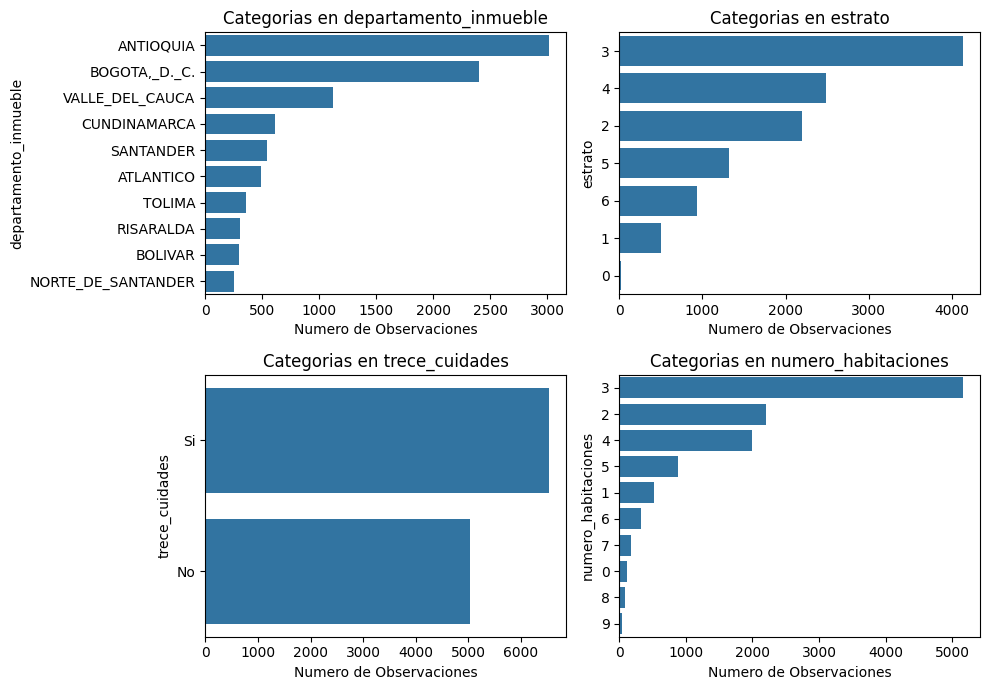

In [423]:

figura, eje = plt.subplots(2, 2, figsize=(10, 7))
ejes = eje.ravel()

columnasInteres = ["departamento_inmueble", "estrato", "trece_cuidades", "numero_habitaciones"]
for i, var in enumerate(columnasInteres):
    try:
        conteo = baseAvaluos[var].astype(int).astype(str).value_counts().head(10)
    except:
        conteo = baseAvaluos[var].value_counts().head(10)       
        
    sns.barplot(x=conteo.values, y=conteo.index, ax=ejes[i])
    
    ejes[i].set_title(f'Categorias en {var}')
    ejes[i].set_xlabel('Numero de Observaciones')
    ejes[i].set_ylabel(f'{var}')

plt.tight_layout()
plt.show()


Igualmente se presenta la distribución de la variable de interés

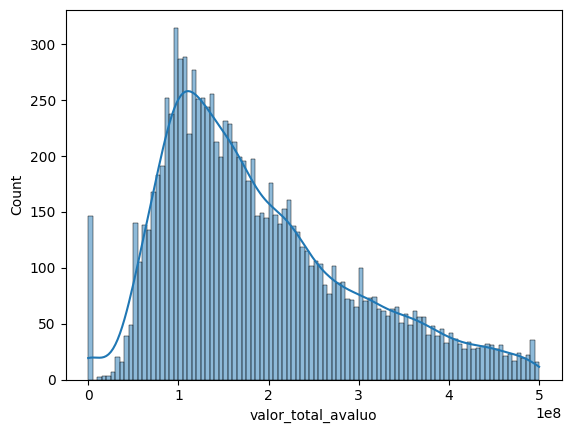

In [424]:
filtroAvaluos = baseAvaluos["valor_total_avaluo"] < 500000000
sns.histplot(baseAvaluos.loc[filtroAvaluos, "valor_total_avaluo"],bins=100, kde=True)
plt.show()

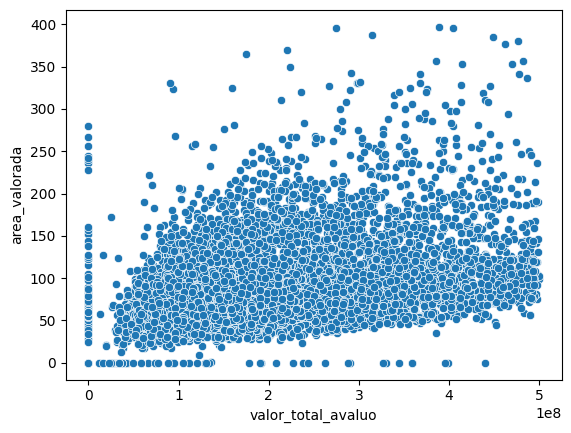

In [425]:
filtroArea = baseAvaluos["area_valorada"] < 400
sns.scatterplot(x=baseAvaluos.loc[filtroAvaluos&filtroArea, "valor_total_avaluo"], y=baseAvaluos.loc[filtroAvaluos&filtroArea, "area_valorada"])
plt.show()

In [426]:
baseEntrenamiento = baseAvaluos.copy()

baseEntrenamiento = baseEntrenamiento[baseEntrenamiento["valor_total_avaluo"].between(1000000, 50000000000)]

variablesCategoricas = ["departamento_inmueble", "andenes_en_las_vias", "estrato", "sala", "comedor","cocina","total_cupos_parquedaro", "numero_total_depositos", "areas_sociales", "estado_terminados","luz_iluminacion", "numero_habitaciones", "numero_banos","otros_espacios", "tipo_uso_inmueble", "trece_cuidades"]
variablesNumericas = list(baseEntrenamiento.columns.difference(variablesCategoricas+["valor_total_avaluo"]))

for variable in variablesCategoricas:
    try:
        baseEntrenamiento[variable] = baseEntrenamiento[variable].astype(int)
    except:
        pass
    variablesNuevas = pd.get_dummies(baseEntrenamiento[variable], drop_first=True, prefix=variable).astype(int)
    
    baseEntrenamiento = pd.concat([baseEntrenamiento, variablesNuevas], axis=1)
    baseEntrenamiento.drop(variable, axis=1, inplace=True)

### ii) Split de los datos

In [427]:
X = baseEntrenamiento.drop("valor_total_avaluo", axis=1).copy()
y = baseEntrenamiento["valor_total_avaluo"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"Datos Originales {X.shape[0]}, Datos Entrenamiento {X_train.shape[0]}, Datos Validacion {X_test.shape[0]}")


Datos Originales 11399, Datos Entrenamiento 9119, Datos Validacion 2280


### iii) Estandarización de las variables numericas

In [428]:
#los outliers se imputan con la mediana
for variable in ["area_construida"]:
    q1 = X_train[variable].quantile(0.25)
    q3 = X_train[variable].quantile(0.75)
    median = X_train[variable].quantile(0.5)
    iqr = q3 - q1
    filtroOutliers = (X_train[variable] <= (q1 - 1.5 * iqr)) | (X_train[variable] >= (q3 + 1.5 * iqr))
    X_train.loc[filtroOutliers, variable] = median
  
    filtroOutliersTesteo = (X_test[variable] <= (q1 - 1.5 * iqr)) | (X_test[variable] >= (q3 + 1.5 * iqr))
    X_test.loc[filtroOutliersTesteo, variable] = median


X_train_cat = X_train.drop(variablesNumericas, axis=1).reset_index(drop=True)
X_test_cat = X_test.drop(variablesNumericas, axis=1).reset_index(drop=True)
X_train_num = X_train[variablesNumericas].copy()
X_test_num = X_test[variablesNumericas].copy()

imputador = SimpleImputer(strategy="mean")
escalador = StandardScaler()

imputador.fit(X_train_num)
escalador.fit(X_train_num)

X_train_num = pd.DataFrame(imputador.transform(X_train_num), columns=variablesNumericas)
X_test_num =  pd.DataFrame(imputador.transform(X_test_num), columns=variablesNumericas)
X_train_num = pd.DataFrame(escalador.transform(X_train_num), columns=variablesNumericas)
X_test_num = pd.DataFrame(escalador.transform(X_test_num), columns=variablesNumericas)

X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)


## CAPITULO III. Modelamiento

In [429]:
grillaModelos = {
    "Lineal":{"modelo":LinearRegression(), 
              "parametros":{}},
    "Lasso":{"modelo":Lasso(),
             "parametros":{"alpha":np.linspace(0.1, 1, 10)}},
    "Ridge":{"modelo":Ridge(), 
             "parametros":{"alpha":np.linspace(0.1, 1, 10)}},
    "Arbol":{"modelo":DecisionTreeRegressor(criterion="absolute_error"), 
             "parametros":{
                 "max_depth":np.linspace(2, 12, 10, dtype=int),
                 "min_samples_split":np.linspace(500, 1000, 100, dtype=int),
                 "min_samples_leaf":np.linspace(100, 500, 50, dtype=int)
              }
             },
    "bosque":{"modelo":RandomForestRegressor(criterion="absolute_error"), 
              "parametros":{
                  "max_depth":np.linspace(1, 10, 10, dtype=int),
                  "min_samples_split":np.linspace(500, 1000, 100, dtype=int),
                  "min_samples_leaf":np.linspace(100, 500, 50, dtype=int)
              }
             },
    "boosting":{"modelo":GradientBoostingRegressor(loss="absolute_error"), 
                "parametros":{
                    "learning_rate":np.linspace(0.01, 0.1, 10),
                    "max_depth":np.linspace(1, 10, 10, dtype=int),
                    "min_samples_split":np.linspace(500, 1000, 100, dtype=int),
                    "min_samples_leaf":np.linspace(0.01, 0.9, 10)
                }
               }
}

for modelo in grillaModelos.keys():
    print(f"Modelo {modelo}")
    if len(grillaModelos[modelo]["parametros"]) != 0:
        modelosEjecutados = RandomizedSearchCV(estimator=grillaModelos[modelo]["modelo"],
                                              param_distributions=grillaModelos[modelo]["parametros"],
                                              n_iter=10,
                                              cv=5,
                                              n_jobs=-1,
                                              verbose=2)

        modelosEjecutados = modelosEjecutados.fit(X_train, y_train)
        predicciones = modelosEjecutados.predict(X_test)
    else:
        modelosEjecutados = grillaModelos[modelo]["modelo"].fit(X_train, y_train)
        predicciones = modelosEjecutados.predict(X_test)
    error = mean_absolute_percentage_error(y_test, predicciones)
    print(f"Error {error}")
    print("------------------------------------------------------------------\n")

Modelo boosting
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Error 0.23701948480226548
------------------------------------------------------------------



In [430]:
# lineal = LinearRegression()
# lineal.fit(X_train, y_train)
# predicciones = lineal.predict(X_test)
# mean_absolute_percentage_error(y_test, predicciones)

In [431]:
# pd.DataFrame({"real":y_test, "prediccion":predicciones}).to_excel("predicciones.xlsx", index=False)

In [432]:
# X_test.to_excel("X_test.xlsx", index=False)